In [1]:
import pandas as pd
import requests
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

C:\Users\wkaco\AppData\Local\Temp\ipykernel_16180\316844021.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
wiki_sp_url = "https://en.wikipedia.org/wiki/List_of_S&P_500_companies"
sp500_comonents = pd.read_html(wiki_sp_url)
sp_df = sp500_comonents[0]
print(sp_df.head())

start_date = '2009-01-01'
end_date = str(date.today())

  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


In [3]:
sp_ticker_list = list(sp_df['Symbol'].values)

In [4]:
sectors = {}
for ticker in sp_ticker_list:
    sector = sp_df.loc[sp_df['Symbol'] == ticker, 'GICS Sector'].values[0]
    if sector not in sectors:
        sectors[sector] = []
    sectors[sector].append(ticker)




In [5]:
df = yf.download(sp_ticker_list, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2009-01-01 -> 2024-11-30)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [6]:
sector_averages = {}
sector_stddevs = {}



for sector, tickers in sectors.items():
    sector_data = df[tickers]
    
    
    sector_averages[sector] = (sector_data / sector_data.shift(1) -1).mean(axis=1)  
    sector_stddevs[sector] =(sector_data / sector_data.shift(1) -1).std(axis=1)     

In [7]:
sector_averages

{'Industrials': Date
 2009-01-02 00:00:00+00:00         NaN
 2009-01-05 00:00:00+00:00   -0.002395
 2009-01-06 00:00:00+00:00    0.017087
 2009-01-07 00:00:00+00:00   -0.035937
 2009-01-08 00:00:00+00:00    0.011476
                                ...   
 2024-11-22 00:00:00+00:00    0.012620
 2024-11-25 00:00:00+00:00    0.009657
 2024-11-26 00:00:00+00:00   -0.000725
 2024-11-27 00:00:00+00:00   -0.002918
 2024-11-29 00:00:00+00:00    0.003098
 Length: 4005, dtype: float64,
 'Health Care': Date
 2009-01-02 00:00:00+00:00         NaN
 2009-01-05 00:00:00+00:00   -0.000834
 2009-01-06 00:00:00+00:00    0.000216
 2009-01-07 00:00:00+00:00   -0.014294
 2009-01-08 00:00:00+00:00    0.003424
                                ...   
 2024-11-22 00:00:00+00:00    0.003914
 2024-11-25 00:00:00+00:00    0.012684
 2024-11-26 00:00:00+00:00   -0.002025
 2024-11-27 00:00:00+00:00    0.005584
 2024-11-29 00:00:00+00:00    0.001333
 Length: 4005, dtype: float64,
 'Information Technology': Date
 2009-

In [8]:
risk_free_rate = yf.download('^TNX', start_date, end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Przygotowanie danych do obliczeń
clear_sector_std = pd.DataFrame(sector_stddevs).dropna()
clear_sector_avr = pd.DataFrame(sector_averages).dropna()

# Dopasowanie dat
common_dates = clear_sector_avr.index.union(risk_free_rate.index)
clear_sector_avr = clear_sector_avr.reindex(common_dates, method='ffill')
clear_sector_std = clear_sector_std.reindex(common_dates, method='ffill')
risk_free_rate = (risk_free_rate - risk_free_rate.shift(1)) / risk_free_rate.shift(1)



In [18]:
type(clear_sector_avr.values)

numpy.ndarray

In [15]:
sharp_ratio = (clear_sector_avr - risk_free_rate.values.reshape(-1, 1) / 100) / clear_sector_std


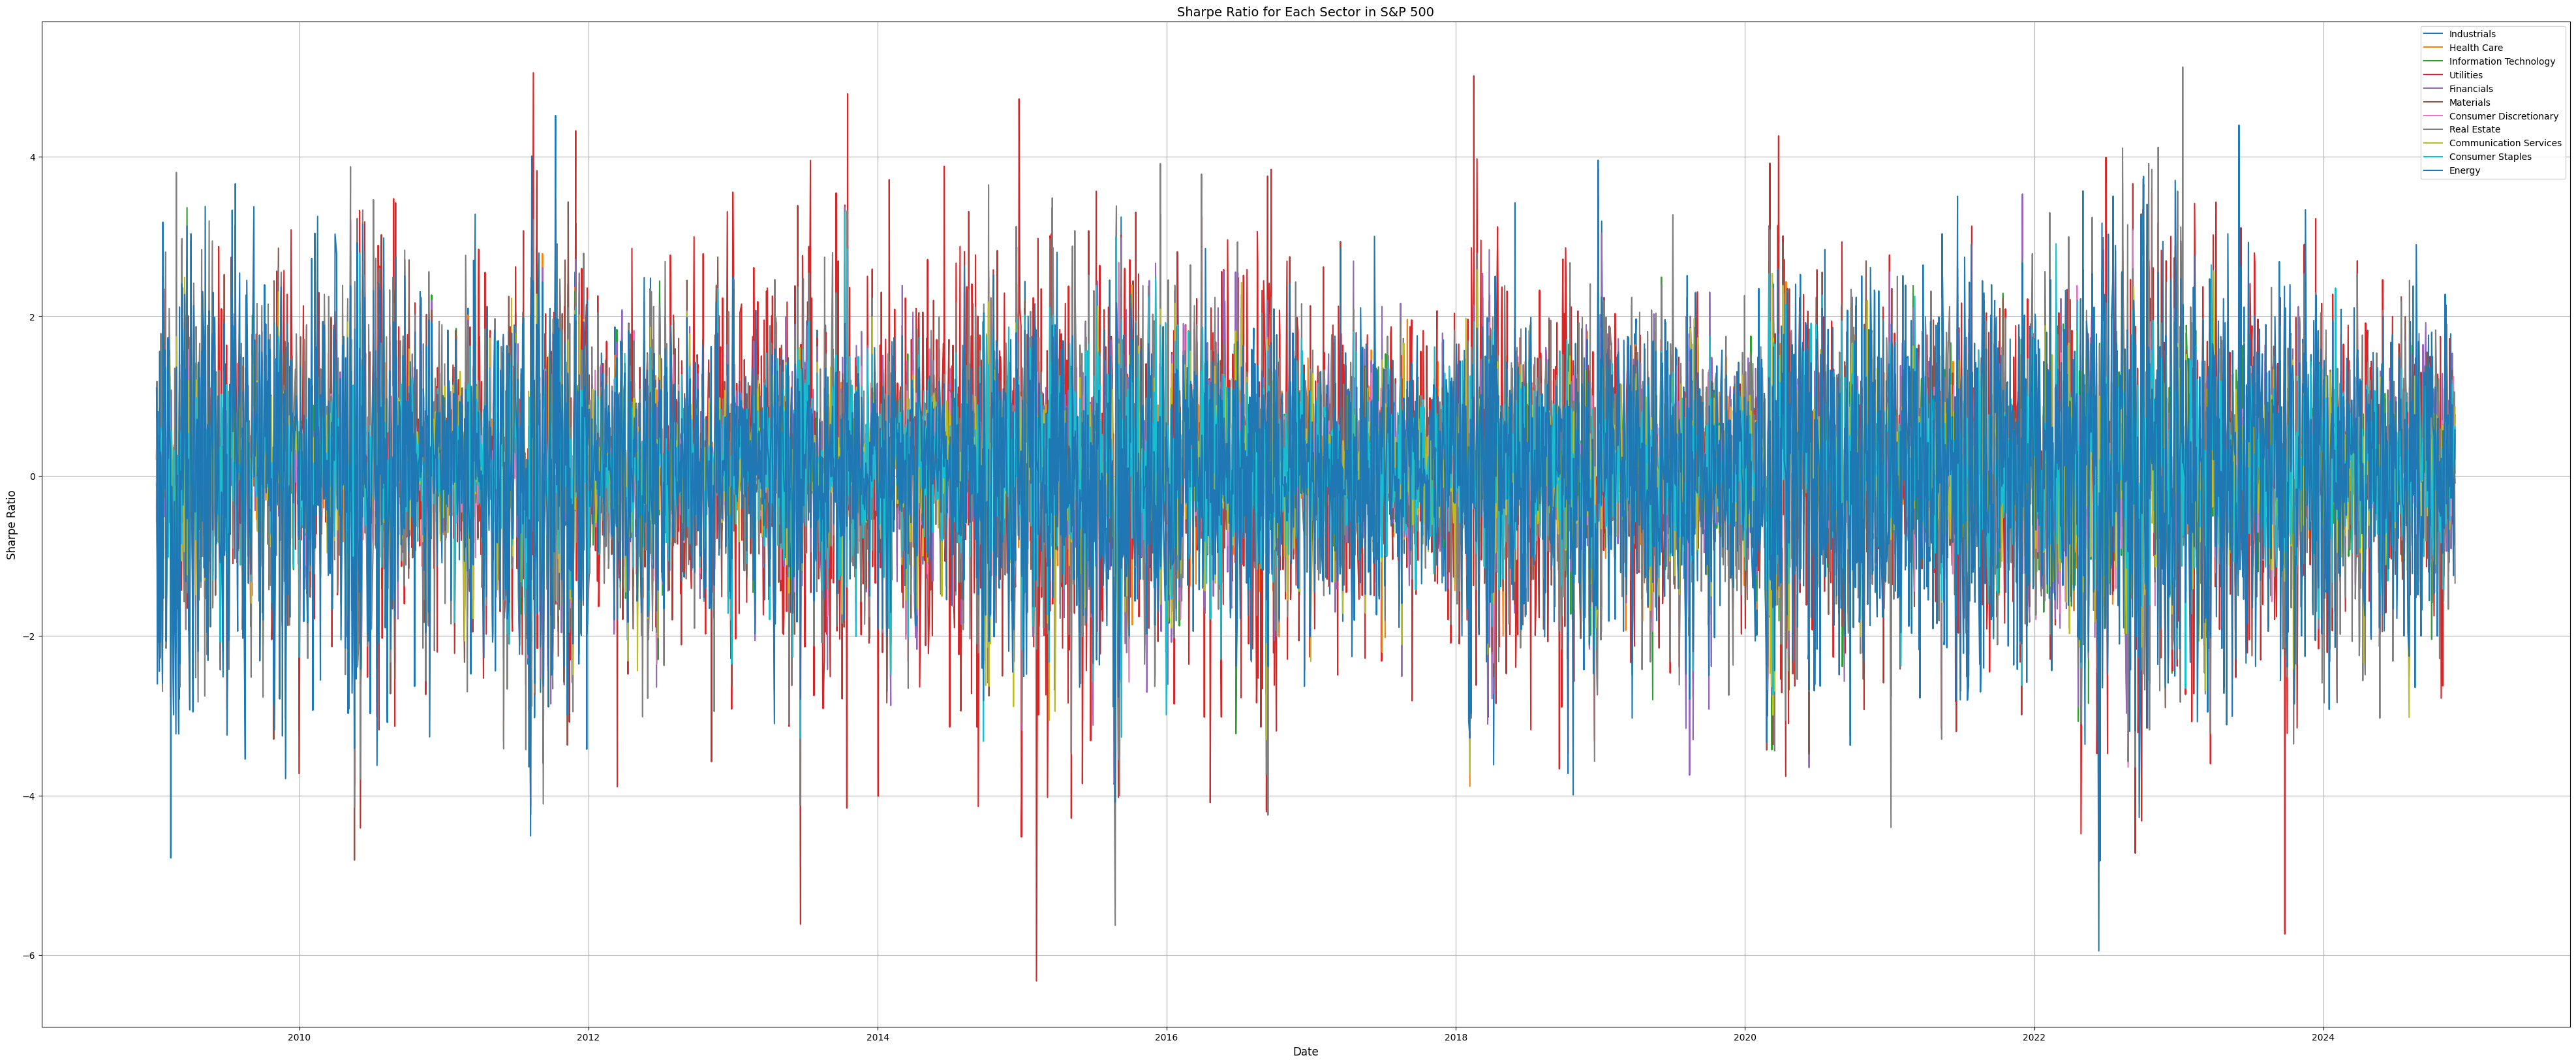

In [14]:
plt.figure(figsize=(50, 20))
for sector in sharp_ratio.columns:
    plt.plot(sharp_ratio.index, sharp_ratio[sector], label=sector)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.title('Sharpe Ratio for Each Sector in S&P 500', fontsize=14)
plt.legend(loc='best')
plt.grid()
plt.show()